# Study of Relationship between EV Sales and EV charging infrastructure
* This notebook contains the analysis of relationship between EV sales and EV charging infrastructure
* Sales Vs Overall Population
---


In [159]:
# Dependencies and Setup
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as st
import seaborn as sns

styles = [dict(selector="caption", props=[("font-size", "120%"),("font-weight", "bold"),("background-color", "wheat"),("font-color","black")])]

lower_year_limit = 2016
higher_year_limit =  2021

## Reading Data
* Sources - US census Bureau https://www.census.gov/topics/population/data.html
* Alternate Fules Data Center - US Department of Energy https://afdc.energy.gov/

In [160]:
# File to Load (Remember to Change These)
ev_charge_station_history = "../Data/ev-charge-stations-in-states-by-year.csv"
ev_sales_per_state = "../Data/ev_per_state_count.csv"
states_population = "../Data/states-population-2010-2020.csv"

# Read data
charge_stations_pre_df = pd.read_csv(ev_charge_station_history)
ev_sales_df = pd.read_csv(ev_sales_per_state)
states_population_pre_df = pd.read_csv(states_population)
charge_stations_pre_df.head()

,State,stations_2021,stations_2020,stations_2019,stations_2018,stations_2017,stations_2016,stations_2015,stations_2014,stations_2013,stations_2012,stations_2011
0,Alabama,276,223,195,165,146,113,101,67,0,4,0
1,Alaska,52,25,19,7,7,3,2,1,50,48,4
2,Arizona,890,574,522,479,432,424,322,309,38,36,11
3,Arkansas,160,112,98,70,62,63,44,41,710,527,43
4,California,14616,7671,6435,5469,4657,4175,3329,2344,5176,3573,1392


### Data Preparation

In [161]:
#Truncate years not relevant
#date_range = pd.period_range("2016-01", "2018-01",freq='m')
drop_station_columns = []
drop_station_columns.append('stations_2021')
for year in range(2011,2016):
    drop_station_columns.append(f'stations_{year}')
charge_stations_df = charge_stations_pre_df.loc[:, charge_stations_pre_df.columns.drop(drop_station_columns)]
    # 'stations_2021','stations_2015','stations_2014','stations_2013','stations_2012','stations_2011'])]

drop_population_columns = []
for year in range(2010,2016):
    drop_population_columns.append(f'population_{year}')
states_population_df = states_population_pre_df.loc[:,states_population_pre_df.columns.drop(drop_population_columns)]
# ['population_2010','population_2011','population_2012','population_2013','population_2014','population_2015'])]

# Merge the data into a single dataset.  
ev_sales_cstation_combo = pd.merge(ev_sales_df, charge_stations_df, on=["State", "State"])
ev_sales_cstation_combo = pd.merge(ev_sales_cstation_combo, states_population_df, on=["State", "State"])


ev_sales_cstation_combo.sort_values(by='State',inplace=True)

# ev_sales_cstation_combo.head()
ev_sales_cstation_combo.head().style.set_caption("EV Sales / Charge Station Ratio").set_table_styles(styles)

,State,sales_2016,sales_2017,sales_2018,sales_2019,sales_2020,stations_2020,stations_2019,stations_2018,stations_2017,stations_2016,population_2016,population_2017,population_2018,population_2019,population_2020
33,Alabama,330,381,866,839,829,223,195,165,146,113,4866824,4877989,4891628,4907965,4921532
46,Alaska,94,85,155,150,148,25,19,7,7,3,742575,740983,736624,733603,731158
9,Arizona,2265,2976,7086,6867,6786,574,522,479,432,424,6944767,7048088,7164228,7291843,7421401
42,Arkansas,138,187,435,422,417,112,98,70,62,63,2991815,3003855,3012161,3020985,3030522
0,California,73854,94873,153442,148710,146951,7671,6435,5469,4657,4175,39149186,39337785,39437463,39437610,39368078


### Correlation of EV Sales and Charging Infrastructure
- Observation - Charging infrastructure has a direct correlation with sales of EV

In [162]:
for year in range(lower_year_limit,higher_year_limit):
    print(f'Year:{year}')
    sales_col_idx = ev_sales_cstation_combo.columns.get_loc(f'sales_{year}')
    station_col_idx = ev_sales_cstation_combo.columns.get_loc(f'stations_{year}')
    sales = ev_sales_cstation_combo.iloc[:,sales_col_idx]
    station = ev_sales_cstation_combo.iloc[:,station_col_idx]
    correlation = round(st.pearsonr(sales,station)[0],2)
    print(f"The correlation between both factors EV sales and charging infrastructure: {correlation}")
    if correlation > 0.5:
        print(f'Implies a strong linear relation')
    elif correlation < 0.5:
        print(f'Implies a medium linear relation')
    elif correlation == 0:
        print(f'Implies NO linear relation')
    elif correlation < 0:
        print(f'Implies a negative linear relation')
    print(f'------------------------------')
    print()

Year:2016
The correlation between both factors EV sales and charging infrastructure: 0.96
Implies a strong linear relation
------------------------------

Year:2017
The correlation between both factors EV sales and charging infrastructure: 0.96
Implies a strong linear relation
------------------------------

Year:2018
The correlation between both factors EV sales and charging infrastructure: 0.97
Implies a strong linear relation
------------------------------

Year:2019
The correlation between both factors EV sales and charging infrastructure: 0.96
Implies a strong linear relation
------------------------------

Year:2020
The correlation between both factors EV sales and charging infrastructure: 0.97
Implies a strong linear relation
------------------------------



### Calculate Ratios

In [163]:

#Compute ratio of sales/charger
ev_sales_cstation_combo["Total EV Sales"] = 0.00
ev_sales_cstation_combo["Total Charge Stations"] = 0.00
ev_sales_cstation_combo["Total Population"] = 0.00
ev_sales_cstation_combo["ev_TslsVsTpop(*1000)"] = 0.00
ev_sales_cstation_combo["ev_TslsVsTchg"] = 0.00

ratio_fields = []
ratio_fields.append('State')
ratio_fields.append('Total EV Sales')
ratio_fields.append('Total Charge Stations')
ratio_fields.append('Total Population')
ratio_fields.append('ev_TslsVsTpop(*1000)')
ratio_fields.append('ev_TslsVsTchg')

cumulative_sales = 0
cumulative_infra = 0
cumulative_population = 0

for year in range(lower_year_limit,higher_year_limit):
    
    ratio_fields.append(f'ev_slsVschg_{year}')
    cumulative_sales = cumulative_sales + ev_sales_cstation_combo[f'sales_{year}']
    cumulative_infra = cumulative_infra + ev_sales_cstation_combo[f'stations_{year}']
    # ev_sales_cstation_combo[f'ev_slsVschg_{year}'] = ev_sales_cstation_combo[f'sales_{year}'] / ev_sales_cstation_combo[f'stations_{year}']
    ev_sales_cstation_combo[f'ev_slsVschg_{year}'] = cumulative_sales / cumulative_infra

    ratio_fields.append(f'ev_slsVspop_{year}')
    cumulative_population = cumulative_population + ev_sales_cstation_combo[f'population_{year}']
    ev_sales_cstation_combo[f'ev_slsVspop_{year}'] = (cumulative_sales / cumulative_population) * 100  #.map("{:.3%}".format)

    ratio_fields.append(f'ev_chgVspop{year}')
    ev_sales_cstation_combo[f'ev_chgVspop{year}'] = (cumulative_infra / cumulative_population) * 100  #.map("{:.3%}".format)

ev_sales_cstation_combo["Total EV Sales"] = cumulative_sales
ev_sales_cstation_combo["Total Charge Stations"] = cumulative_infra
ev_sales_cstation_combo["Total Population"] = cumulative_population

#   ev_sales_cstation_combo["Total EV Sales"] = ev_sales_cstation_combo["Total EV Sales"]  + ev_sales_cstation_combo[f'sales_{year}']
#    ev_sales_cstation_combo["Total Charge Stations"] = ev_sales_cstation_combo["Total Charge Stations"]  + ev_sales_cstation_combo[f'stations_{year}']
#    ev_sales_cstation_combo["Total Population"] = ev_sales_cstation_combo["Total Population"] + ev_sales_cstation_combo[f'population_{year}']

# ['State','2016','ev_sls%_2016', '2017','ev_sls%_2017''2018', 'ev_sls%_2016''2019','2020','Total EV Sales', 'Total Charge Stations']
ev_sales_cstation_combo[f'ev_TslsVsTpop(*1000)'] = ((ev_sales_cstation_combo['Total EV Sales'] / ev_sales_cstation_combo['Total Population'])*1000) #.map("{:.3%}".format)
ev_sales_cstation_combo[f'ev_TslsVsTchg'] = ((ev_sales_cstation_combo['Total EV Sales'] / ev_sales_cstation_combo['Total Charge Stations'])) #.map("{:.3%}".format)

ev_sales_cstation_ratio = ev_sales_cstation_combo[ratio_fields]
ev_sales_cstation_ratio["State"].apply(str)
ev_sales_cstation_ratio

# for year in range(lower_year_limit,higher_year_limit):
ev_sales_cstation_ratio.style.set_caption("EV Sales / Charge Station Ratio")
ev_sales_cstation_ratio.style.set_table_styles(styles)



,State,Total EV Sales,Total Charge Stations,Total Population,ev_TslsVsTpop(*1000),ev_TslsVsTchg,ev_slsVschg_2016,ev_slsVspop_2016,ev_chgVspop2016,ev_slsVschg_2017,ev_slsVspop_2017,ev_chgVspop2017,ev_slsVschg_2018,ev_slsVspop_2018,ev_chgVspop2018,ev_slsVschg_2019,ev_slsVspop_2019,ev_chgVspop2019,ev_slsVschg_2020,ev_slsVspop_2020,ev_chgVspop2020
33,Alabama,3245,842,24465938,0.132633,3.853919,2.920354,0.006781,0.002322,2.745174,0.007296,0.002658,3.719340,0.010774,0.002897,3.903069,0.012362,0.003167,3.853919,0.013263,0.003442
46,Alaska,632,61,3684943,0.171509,10.360656,31.333333,0.012659,0.000404,17.900000,0.012066,0.000674,19.647059,0.015044,0.000766,13.444444,0.016386,0.001219,10.360656,0.017151,0.001655
9,Arizona,25980,2431,35870327,0.724276,10.686960,5.341981,0.032614,0.006105,6.122664,0.037455,0.006117,9.233708,0.058264,0.006310,10.336026,0.067468,0.006527,10.686960,0.072428,0.006777
42,Arkansas,1599,405,15059338,0.106180,3.948148,2.190476,0.004613,0.002106,2.600000,0.005421,0.002085,3.897436,0.008437,0.002165,4.034130,0.009826,0.002436,3.948148,0.010618,0.002689
0,California,617830,28407,196730122,3.140495,21.749217,17.689581,0.188648,0.010664,19.104053,0.214975,0.011253,22.527725,0.273200,0.012127,22.708285,0.299233,0.013177,21.749217,0.314050,0.014440
8,Colorado,27505,3630,28424625,0.967647,7.577135,6.119639,0.048901,0.007991,6.880762,0.061525,0.008942,8.153486,0.082558,0.010126,8.080997,0.091754,0.011354,7.577135,0.096765,0.012771
18,Connecticut,13811,1955,17852743,0.773607,7.064450,4.457227,0.042209,0.009470,5.497118,0.053318,0.009699,6.713092,0.067383,0.010038,7.031354,0.073728,0.010486,7.064450,0.077361,0.010951
37,Delaware,2573,244,4838393,0.531788,10.545082,11.233333,0.035474,0.003158,11.014925,0.038681,0.003512,11.666667,0.047480,0.004070,11.339080,0.051226,0.004518,10.545082,0.053179,0.005043
2,Florida,52940,6729,106084620,0.499036,7.867439,6.481865,0.030324,0.004678,6.170274,0.030833,0.004997,7.932138,0.042210,0.005321,8.113919,0.047201,0.005817,7.867439,0.049904,0.006343
14,Georgia,22435,3939,52582899,0.426660,5.695608,4.148211,0.023621,0.005694,3.801407,0.023459,0.006171,5.303075,0.034777,0.006558,5.692596,0.039847,0.007000,5.695608,0.042666,0.007491


### Highest EV Sales and Charge Infra Ratio (on Total)
- It is observed that increase in charging infrastructure has a direct impact on the sales, case in point california where the sales dropped in 2019 with drop in charging infra
- Oregon on the other hand continued to grow until 2020 where there is a drop in both charging infra and sales

In [164]:
# Sort the schools by the latest year in descending order and display the top 5 rows.
latest_highest_adoption = ev_sales_cstation_ratio.sort_values(by='ev_TslsVsTchg',ascending=False, axis=0)
latest_highest_adoption.head(5).style.set_caption(f'Highest EV Sales and Charge Infra Ratio').set_table_styles(styles)

,State,Total EV Sales,Total Charge Stations,Total Population,ev_TslsVsTpop(*1000),ev_TslsVsTchg,ev_slsVschg_2016,ev_slsVspop_2016,ev_chgVspop2016,ev_slsVschg_2017,ev_slsVspop_2017,ev_chgVspop2017,ev_slsVschg_2018,ev_slsVspop_2018,ev_chgVspop2018,ev_slsVschg_2019,ev_slsVspop_2019,ev_chgVspop2019,ev_slsVschg_2020,ev_slsVspop_2020,ev_chgVspop2020
0,California,617830,28407,196730122,3.140495,21.749217,17.689581,0.188648,0.010664,19.104053,0.214975,0.011253,22.527725,0.273200,0.012127,22.708285,0.299233,0.013177,21.749217,0.314050,0.014440
5,New Jersey,36028,1832,44427090,0.810947,19.665939,16.311475,0.044852,0.002750,17.707269,0.050744,0.002866,22.329253,0.068445,0.003065,21.340659,0.076490,0.003584,19.665939,0.081095,0.004124
24,Oklahoma,8806,573,19746692,0.445948,15.368237,4.870370,0.006695,0.001375,8.368421,0.012135,0.001450,20.318436,0.030808,0.001516,20.119355,0.039560,0.001966,15.368237,0.044595,0.002902
9,Arizona,25980,2431,35870327,0.724276,10.686960,5.341981,0.032614,0.006105,6.122664,0.037455,0.006117,9.233708,0.058264,0.006310,10.336026,0.067468,0.006527,10.686960,0.072428,0.006777
37,Delaware,2573,244,4838393,0.531788,10.545082,11.233333,0.035474,0.003158,11.014925,0.038681,0.003512,11.666667,0.047480,0.004070,11.339080,0.051226,0.004518,10.545082,0.053179,0.005043


### Lowest EV Sales and Charge Infra Ratio (on Total)
- It is observed that due to decrease in charging infrastructure the sales has dropped, case in point Mississippi, between 2018 and 2020
- Also there are states where the charging infrastructure has not

In [165]:
# Sort by  total sales Vs total charge ascending to find the lowest sales vs charge infra 
latest_highest_adoption = ev_sales_cstation_ratio.sort_values(by='ev_TslsVsTchg',ascending=True)
latest_highest_adoption.head(5).style.set_caption(f'Lowest EV Sales and Charge Infra Ratio').set_table_styles(styles)

,State,Total EV Sales,Total Charge Stations,Total Population,ev_TslsVsTpop(*1000),ev_TslsVsTchg,ev_slsVschg_2016,ev_slsVspop_2016,ev_chgVspop2016,ev_slsVschg_2017,ev_slsVspop_2017,ev_chgVspop2017,ev_slsVschg_2018,ev_slsVspop_2018,ev_chgVspop2018,ev_slsVschg_2019,ev_slsVspop_2019,ev_chgVspop2019,ev_slsVschg_2020,ev_slsVspop_2020,ev_chgVspop2020
48,Wyoming,361,232,2906735,0.124194,1.556034,1.281250,0.007006,0.005468,1.333333,0.007895,0.005922,1.614035,0.010549,0.006536,1.596491,0.011745,0.007357,1.556034,0.012419,0.007981
45,West Virginia,822,383,9037121,0.090958,2.146214,1.651163,0.003875,0.002347,1.642857,0.005040,0.003068,2.000000,0.007367,0.003683,2.113793,0.008452,0.003999,2.146214,0.009096,0.004238
44,Mississippi,874,342,14909161,0.058622,2.555556,1.707317,0.002341,0.001371,2.020408,0.003310,0.001638,2.750000,0.004786,0.001740,2.755274,0.005468,0.001985,2.555556,0.005862,0.002294
47,South Dakota,511,168,4396655,0.116225,3.041667,1.608696,0.004284,0.002663,2.367347,0.006677,0.002820,3.060976,0.009592,0.003134,3.105691,0.010902,0.003510,3.041667,0.011622,0.003821
27,Tennessee,7483,2279,33861364,0.220989,3.283458,1.997664,0.012855,0.006435,1.881143,0.012315,0.006546,2.730683,0.018070,0.006617,3.120381,0.020660,0.006621,3.283458,0.022099,0.006730


## Create sub-data frames:(Top and bottom 10)

### Sales-Charging Ratio

In [166]:
ratio_fields = []
ratio_fields.append('State')
for year in range(lower_year_limit,higher_year_limit):
        ratio_fields.append(f'ev_slsVschg_{year}')

ev_slsVschg_top10 = ev_sales_cstation_ratio.sort_values(by='ev_TslsVsTchg',ascending=False).head(5)[ratio_fields]
ev_slsVschg_top10.set_index("State")

ev_slsVschg_bot10 = ev_sales_cstation_ratio.sort_values(by='ev_TslsVsTchg',ascending=True).head(5)[ratio_fields]
ev_slsVschg_bot10.set_index("State")


,ev_slsVschg_2016,ev_slsVschg_2017,ev_slsVschg_2018,ev_slsVschg_2019,ev_slsVschg_2020
State,,,,,
Wyoming,1.281250,1.333333,1.614035,1.596491,1.556034
West Virginia,1.651163,1.642857,2.000000,2.113793,2.146214
Mississippi,1.707317,2.020408,2.750000,2.755274,2.555556
South Dakota,1.608696,2.367347,3.060976,3.105691,3.041667
Tennessee,1.997664,1.881143,2.730683,3.120381,3.283458


### Transporse, Merge and plot the Top10 and Bottom10 and for visual analysis

In [167]:
ev_TBslsVschg_plot = pd.concat([ev_slsVschg_top10,ev_slsVschg_bot10]).set_index("State")
ev_TBslsVschg_plot

for year in range(lower_year_limit,higher_year_limit):
         field_name = (f'ev_slsVschg_{year}')
         ev_TBslsVschg_plot.rename(columns={ field_name: year},inplace=True)
ev_TBslsVschg_plot_transpose = ev_TBslsVschg_plot.transpose()
ev_TBslsVschg_plot_transpose
# ev_TBslsVschg_plot_transpose["State"] = ev_TBslsVschg_plot_transpose["State"].astype('str')

State,California,New Jersey,Oklahoma,Arizona,Delaware,Wyoming,West Virginia,Mississippi,South Dakota,Tennessee
2016,17.689581,16.311475,4.870370,5.341981,11.233333,1.281250,1.651163,1.707317,1.608696,1.997664
2017,19.104053,17.707269,8.368421,6.122664,11.014925,1.333333,1.642857,2.020408,2.367347,1.881143
2018,22.527725,22.329253,20.318436,9.233708,11.666667,1.614035,2.000000,2.750000,3.060976,2.730683
2019,22.708285,21.340659,20.119355,10.336026,11.339080,1.596491,2.113793,2.755274,3.105691,3.120381
2020,21.749217,19.665939,15.368237,10.686960,10.545082,1.556034,2.146214,2.555556,3.041667,3.283458


Text(0, 0.5, 'Ratio (Sales/Charge Infra)')

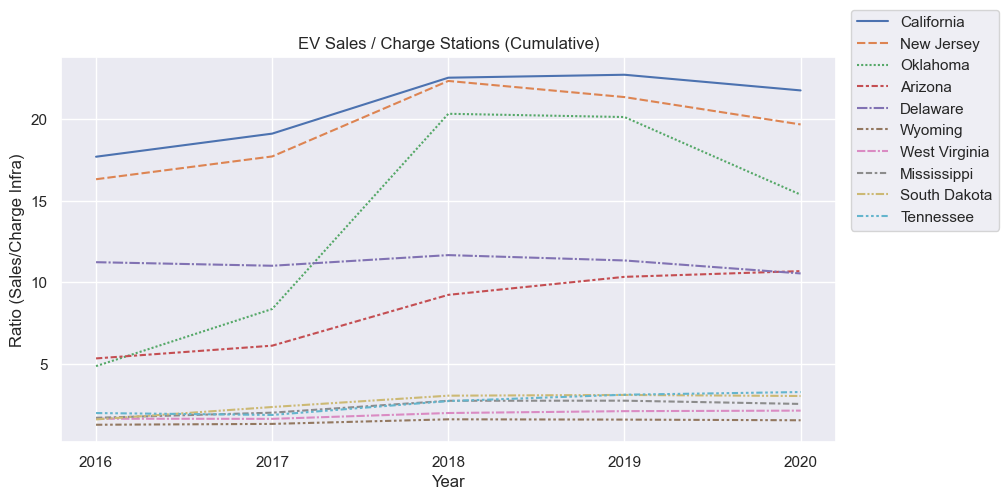

In [168]:
#define figure size
x_ticks_year = []
for year in range(lower_year_limit,higher_year_limit):
         x_ticks_year.append(year)

sns.set(rc={"figure.figsize":(10, 5)}) #width=8, height=4
lpt = sns.lineplot(data=ev_TBslsVschg_plot_transpose)
lpt.set(title = 'EV Sales / Charge Stations (Cumulative)')
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='lower left', borderaxespad=0,)
plt.xticks(x_ticks_year)
plt.xlabel('Year')
plt.ylabel('Ratio (Sales/Charge Infra)')

### Sales-Population Ratio

In [169]:
ratio_fields = []
ratio_fields.append('State')
for year in range(lower_year_limit,higher_year_limit):
        ratio_fields.append(f'ev_slsVspop_{year}')

ev_slsVspop_top10 = ev_sales_cstation_ratio.sort_values(by='ev_TslsVsTpop(*1000)',ascending=False).head(5)[ratio_fields]
ev_slsVspop_top10.set_index("State")

ev_slsVspop_bot10 = ev_sales_cstation_ratio.sort_values(by='ev_TslsVsTpop(*1000)',ascending=True).head(5)[ratio_fields]
ev_slsVspop_bot10.set_index("State")


,ev_slsVspop_2016,ev_slsVspop_2017,ev_slsVspop_2018,ev_slsVspop_2019,ev_slsVspop_2020
State,,,,,
Mississippi,0.002341,0.003310,0.004786,0.005468,0.005862
West Virginia,0.003875,0.005040,0.007367,0.008452,0.009096
North Dakota,0.005290,0.005222,0.007655,0.008760,0.009390
Louisiana,0.005768,0.005911,0.008317,0.009423,0.010063
Arkansas,0.004613,0.005421,0.008437,0.009826,0.010618


### Transporse, Merge and plot the Top10 and Bottom10 and for visual analysis

In [170]:
ev_TBslsVspop_plot = pd.concat([ev_slsVspop_top10,ev_slsVspop_bot10]).set_index("State")
ev_TBslsVspop_plot

for year in range(lower_year_limit,higher_year_limit):
         field_name = (f'ev_slsVspop_{year}')
         ev_TBslsVspop_plot.rename(columns={ field_name: year},inplace=True)
ev_TBslsVspop_plot_transpose = ev_TBslsVspop_plot.transpose()
ev_TBslsVspop_plot_transpose

State,California,Hawaii,Washington,Vermont,Oregon,Mississippi,West Virginia,North Dakota,Louisiana,Arkansas
2016,0.188648,0.085661,0.073466,0.082324,0.085164,0.002341,0.003875,0.005290,0.005768,0.004613
2017,0.214975,0.110627,0.084404,0.110845,0.090698,0.003310,0.005040,0.005222,0.005911,0.005421
2018,0.273200,0.127497,0.112700,0.117857,0.108257,0.004786,0.007367,0.007655,0.008317,0.008437
2019,0.299233,0.134876,0.125017,0.120400,0.115635,0.005468,0.008452,0.008760,0.009423,0.009826
2020,0.314050,0.139119,0.131664,0.121633,0.119554,0.005862,0.009096,0.009390,0.010063,0.010618


Text(0, 0.5, 'Ratio (Sales/Total Population)')

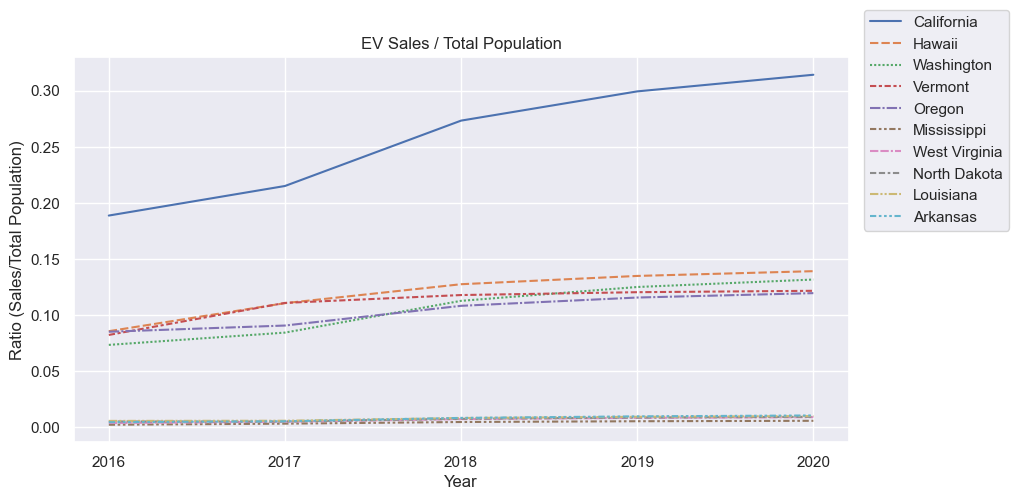

In [171]:
x_ticks_year = []
for year in range(lower_year_limit,higher_year_limit):
         x_ticks_year.append(year)

sns.set(rc={"figure.figsize":(10, 5)}) #width=8, height=4
lpt = sns.lineplot(data=ev_TBslsVspop_plot_transpose)
lpt.set(title = 'EV Sales / Total Population')
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='lower left', borderaxespad=0,)
plt.xticks(x_ticks_year)
plt.xlabel('Year')
plt.ylabel('Ratio (Sales/Total Population)')

### Charging Infra -Population Ratio

In [173]:
ratio_fields = []
ratio_fields.append('State')
for year in range(lower_year_limit,higher_year_limit):
        ratio_fields.append(f'ev_chgVspop{year}')

ev_chgVspop_top10 = ev_sales_cstation_ratio.sort_values(by='Total Charge Stations',ascending=False).head(5)[ratio_fields]
ev_chgVspop_top10.set_index("State")

ev_chgVspop_bot10 = ev_sales_cstation_ratio.sort_values(by='Total Charge Stations',ascending=True).head(5)[ratio_fields]
ev_chgVspop_bot10.set_index("State")

ev_TBchgVspop_plot = pd.concat([ev_chgVspop_top10,ev_chgVspop_bot10]).set_index("State")
ev_TBchgVspop_plot

for year in range(lower_year_limit,higher_year_limit):
         field_name = (f'ev_chgVspop{year}')
         ev_TBchgVspop_plot.rename(columns={ field_name: year},inplace=True)
ev_TBchgVspop_plot_transpose = ev_TBchgVspop_plot.transpose()
ev_TBchgVspop_plot_transpose

x_ticks_year = []
for year in range(lower_year_limit,higher_year_limit):
         x_ticks_year.append(year)

sns.set(rc={"figure.figsize":(10, 5)}) #width=8, height=4
lpt = sns.lineplot(data=ev_TBchgVspop_plot_transpose)
lpt.set(title = 'Charge Station Per Capita')
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='lower left', borderaxespad=0,)
plt.xticks(x_ticks_year)
plt.xlabel('Year')
plt.ylabel('Charge Station Per Capita')

,ev_chgVspop2016,ev_chgVspop2017,ev_chgVspop2018,ev_chgVspop2019,ev_chgVspop2020
State,,,,,
Alaska,0.000404,0.000674,0.000766,0.001219,0.001655
North Dakota,0.000926,0.001124,0.001628,0.002141,0.002709
South Dakota,0.002663,0.002820,0.003134,0.003510,0.003821
Wyoming,0.005468,0.005922,0.006536,0.007357,0.007981
Montana,0.003454,0.003292,0.003547,0.003950,0.004370


---------------------------
#Summary Report

From analyzing various data points from Sales Vs Charge infrastructure
 1. There seems to be a direct correlation between sales vs charge infrastructure
 2. The charge infrastructure in some states do have a saturation point
 3. 
---------------------------